In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,make_scorer,r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

import lightgbm as lgb

import random
np.random.seed(42)
random.seed(42)

In [2]:
df_diamonds = pd.read_csv("diamonds.csv")
df_diamond = df_diamonds.drop(columns = "Unnamed: 0")

train_set, test_set = train_test_split(df_diamond, test_size = 0.2)

train_features = train_set.drop(columns = "price")
train_labels = pd.DataFrame(train_set["price"])

test_features = test_set.drop(columns = "price")
test_labels = pd.DataFrame(test_set["price"])

In [3]:
#Pipeline only cat
num_attributes = ["carat","depth","table","x","y","z"]
cat_cut_level = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']] 
cat_color_level = [['J', 'I', 'H', 'G', 'F', 'E', 'D']]
cat_clarity_level = [['I1', 'SI2', 'SI1', 'VS2','VS1', 'VVS2','VVS1', 'IF']]
cat_attributes= ["cut","color","clarity"]

full_pipeline_cat = ColumnTransformer(
    transformers = [
    ("cat_cut",     OrdinalEncoder(categories=cat_cut_level),["cut"]),
    ("cat_color",   OrdinalEncoder(categories=cat_color_level),["color"]),
    ("cat_clarity", OrdinalEncoder(categories=cat_clarity_level),["clarity"])
    ],
    remainder = "passthrough"
)
    
train_features_cat = full_pipeline_cat.fit_transform(train_features)
test_features_cat = full_pipeline_cat.transform(test_features)

if(full_pipeline_cat.sparse_output_):
    train_features_cat = train_features_cat.toarray()
    test_features_cat = test_features_cat.toarray()
    
#Make them dataframe
df_train_features_cat = pd.DataFrame(train_features_cat, columns =  cat_attributes + num_attributes )
df_test_features_cat = pd.DataFrame(test_features_cat, columns = cat_attributes + num_attributes )

In [4]:
#Pipeline with standardscaler
num_attributes = ["carat","depth","table","x","y","z"]
all_atributes =  cat_attributes + num_attributes

num_pipeline_scaler = Pipeline([
    ('std_scaler',StandardScaler()),
])


full_pipeline_scaler = ColumnTransformer(
    transformers = [
    ("num", num_pipeline_scaler, all_atributes),
    ],
    remainder = "passthrough"
)
    

train_features_ss = full_pipeline_scaler.fit_transform(df_train_features_cat)
test_features_ss = full_pipeline_scaler.transform(df_test_features_cat)

if(full_pipeline_scaler.sparse_output_):
    train_features_ss = train_features_ss.toarray()
    test_features_ss = test_features_ss.toarray()
    
#Make them dataframe
df_train_features_ss = pd.DataFrame(train_features_ss, columns = all_atributes)
df_test_features_ss  = pd.DataFrame(test_features_ss, columns = all_atributes)

In [5]:
label_process_ss = StandardScaler()
train_labels_ss = label_process_ss.fit_transform(train_labels)
test_labels_ss = label_process_ss.transform(test_labels)
   
#Make them dataframe
df_train_labels_ss = pd.DataFrame(train_labels_ss, columns = ["price"])
df_test_labels_ss  = pd.DataFrame(test_labels_ss, columns = ["price"])

In [ ]:
'''
lightgbm.LGBMModel(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, 
            n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, 
            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
            subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
            random_state=None, n_jobs=None, importance_type='split', **kwargs)    
'''

In [86]:
X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# pipeline class 
pipe = Pipeline([
    ('model', lgb.LGBMRegressor(random_state=42))
])

# explicit dimension classes 
lgb_search = {
    'model': Categorical([lgb.LGBMRegressor(random_state=42)]),
    'model__learning_rate': Real(0.00001, 0.9, prior='log-uniform'),
    'model__max_depth': Integer(-1,500),
    'model__num_iterations': Integer(2, 500),
    'model__num_leaves': Integer(5,500),
    'model__colsample_bytree': Real(0.05, 1.0, 'uniform'), 
    'model__subsample': Real(0.05, 1.0, 'uniform'),
    'model__reg_lambda': Real(1e-8, 1e+3, 'log-uniform'),      
    'model__reg_alpha': Real(1e-8, 1e+3, 'log-uniform'),         
    'model__n_estimators': Integer(5,500),
    'model__min_data_in_leaf': Integer(2,200)
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(lgb_search)],
    cv=KFold(n_splits=10,shuffle = True, random_state = 42),
    scoring=('neg_root_mean_squared_error'),
    verbose=10,
    return_train_score=True,
    iid=False,
    n_jobs=-1
)

# print("val. score: %s" % opt.best_score_)
# print("test score: %s" % opt.score(X_test, y_test))
# print("best params: %s" % str(opt.best_params_))

c:\Users\eraye\anaconda3\envs\ece219\lib\site-packages\skopt\searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [87]:
array_train = np.array(df_train_features_ss)
array_label = np.array(df_train_labels_ss).ravel()
opt.fit(array_train, array_label)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

c:\Users\eraye\anaconda3\envs\ece219\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('model',
                                         LGBMRegressor(random_state=42))]),
              iid=False, n_jobs=-1, return_train_score=True,
              scoring='neg_root_mean_squared_error',
              search_spaces=[{'model': Categorical(categories=(LGBMRegressor(colsample_bytree=0.6161939973228585,
              learning_rate=0.3781197184596576, min...
                              'model__num_leaves': Integer(low=5, high=500, prior='uniform', transform='normalize'),
                              'model__reg_alpha': Real(low=1e-08, high=1000.0, prior='log-uniform', transform='normalize'),
                              'model__reg_lambda': Real(low=1e-08, high=1000.0, prior='log-uniform', transform='normalize'),
                              'model__subsample': Real(low=0.05, high=1.0, prior='uniform', transform='normalize')}],
              verbose=10)

In [88]:
import joblib
joblib.dump(opt, 'rf_bayes_search.pkl')
bayes_search = joblib.load('rf_bayes_search.pkl')

In [89]:
df_b = pd.DataFrame(bayes_search.cv_results_)
sorted_b = df_b.sort_values(by='rank_test_score', ascending=True)
sorted_b.iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__min_data_in_leaf,param_model__n_estimators,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,rank_train_score
49,18.131434,3.983569,5.202325,1.664297,LGBMRegressor(colsample_bytree=0.6161939973228...,0.616194,0.37812,-1,2,5,...,-0.082477,-0.082622,-0.082289,-0.083223,-0.082679,-0.082578,-0.083124,-0.082664,0.000301,6
17,19.236665,3.774313,4.959430,1.616371,LGBMRegressor(colsample_bytree=0.6161939973228...,1.0,0.128099,500,2,5,...,-0.104566,-0.104299,-0.103904,-0.104996,-0.104750,-0.103751,-0.105402,-0.104454,0.000493,15
38,13.212834,0.489341,2.831013,1.074469,LGBMRegressor(colsample_bytree=0.6161939973228...,1.0,0.260282,-1,2,500,...,-0.093003,-0.092931,-0.091941,-0.093423,-0.093933,-0.092174,-0.093818,-0.093011,0.000626,11
41,5.345807,1.057395,0.933387,0.292048,LGBMRegressor(colsample_bytree=0.6161939973228...,0.646544,0.536326,448,200,500,...,-0.113311,-0.112811,-0.113243,-0.114220,-0.113839,-0.113351,-0.114102,-0.113553,0.000454,19
19,10.246004,2.021687,2.505298,0.906581,LGBMRegressor(colsample_bytree=0.6161939973228...,1.0,0.076939,-1,200,463,...,-0.114750,-0.114916,-0.114100,-0.115891,-0.115239,-0.115357,-0.115496,-0.115001,0.000489,20
28,6.020670,0.910055,0.815924,0.285916,LGBMRegressor(colsample_bytree=0.6161939973228...,1.0,0.370727,500,200,8,...,-0.117018,-0.118069,-0.117137,-0.118081,-0.117886,-0.117833,-0.117667,-0.117684,0.000421,21
33,4.577092,0.656344,0.705850,0.238710,LGBMRegressor(colsample_bytree=0.6161939973228...,0.801205,0.9,500,200,5,...,-0.108591,-0.109046,-0.108472,-0.109220,-0.108635,-0.109190,-0.109274,-0.108977,0.000327,18
18,9.411403,1.700210,2.219613,0.735832,LGBMRegressor(colsample_bytree=0.6161939973228...,1.0,0.043163,500,200,5,...,-0.120551,-0.120811,-0.120084,-0.121256,-0.121401,-0.121088,-0.120637,-0.120817,0.000413,23
44,14.706347,2.630130,3.015857,1.102997,LGBMRegressor(colsample_bytree=0.6161939973228...,1.0,0.410415,-1,2,500,...,-0.087593,-0.087219,-0.087461,-0.088035,-0.088250,-0.087129,-0.088468,-0.087707,0.000438,10
45,7.100674,1.694131,1.296659,0.504579,LGBMRegressor(colsample_bytree=0.6161939973228...,0.74819,0.185593,-1,200,5,...,-0.122749,-0.122903,-0.122603,-0.123170,-0.123352,-0.123032,-0.123223,-0.123093,0.000363,24


In [104]:
preds = opt.predict(np.array(df_test_features_ss))
r2 = r2_score(np.array(df_test_labels_ss).ravel(), preds)
rmse = mean_squared_error(np.array(df_test_labels_ss).ravel(), preds, squared=False)
print("Train RMSE for best model: " , -sorted_b.iloc[0, -3])
print("Best Avg. Val. RMSE: ", -opt.best_score_)
print("Test RMSE: " , rmse)
print("Test R2: " ,r2)

Train RMSE for best model:  0.08266412480421267
Best Avg. Val. RMSE:  0.1351186150256916
Test RMSE:  0.13390073277918696
Test R2:  0.9820447197503055


In [105]:
opt.best_params_

OrderedDict([('model',
              LGBMRegressor(colsample_bytree=0.6161939973228585,
                            learning_rate=0.3781197184596576, min_data_in_leaf=2,
                            n_estimators=5, num_iterations=500, num_leaves=500,
                            random_state=42, reg_alpha=3.114946274779621e-07,
                            reg_lambda=1000.0, subsample=0.05)),
             ('model__colsample_bytree', 0.6161939973228585),
             ('model__learning_rate', 0.3781197184596576),
             ('model__max_depth', -1),
             ('model__min_data_in_leaf', 2),
             ('model__n_estimators', 5),
             ('model__num_iterations', 500),
             ('model__num_leaves', 500),
             ('model__reg_alpha', 3.114946274779621e-07),
             ('model__reg_lambda', 1000.0),
             ('model__subsample', 0.05)])

In [106]:
opt.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model', 'param_model__colsample_bytree', 'param_model__learning_rate', 'param_model__max_depth', 'param_model__min_data_in_leaf', 'param_model__n_estimators', 'param_model__num_iterations', 'param_model__num_leaves', 'param_model__reg_alpha', 'param_model__reg_lambda', 'param_model__subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score', 'rank_train_score'])

In [107]:
sorted_b.keys()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model', 'param_model__colsample_bytree',
       'param_model__learning_rate', 'param_model__max_depth',
       'param_model__min_data_in_leaf', 'param_model__n_estimators',
       'param_model__num_iterations', 'param_model__num_leaves',
       'param_model__reg_alpha', 'param_model__reg_lambda',
       'param_model__subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_score',
       'split9_train_score', 'mean_train_score', 'std_t

<AxesSubplot: >

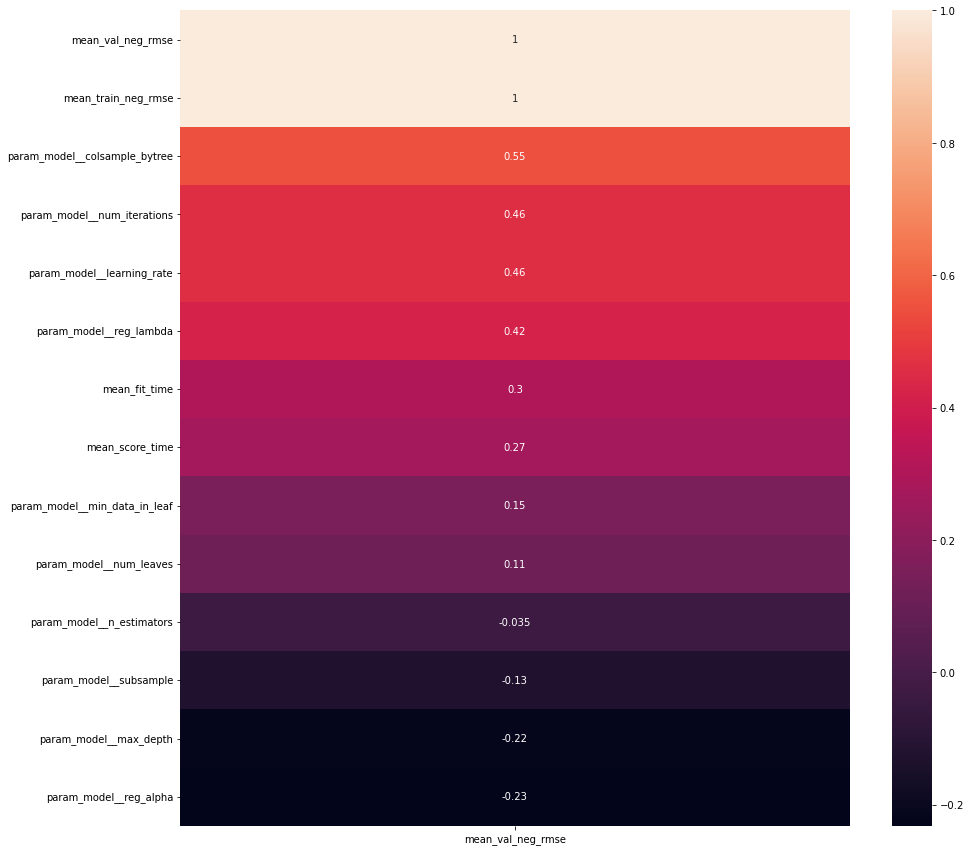

In [123]:
import seaborn as sns
hparam_list = [
       'param_model__colsample_bytree', 
       'param_model__learning_rate', 
       'param_model__max_depth',
       'param_model__min_data_in_leaf', 
       'param_model__n_estimators', 
       'param_model__num_iterations',
       'param_model__num_leaves', 
       'param_model__reg_alpha', 
       'param_model__reg_lambda',
       'param_model__subsample',
       'mean_test_score',
       'mean_fit_time',
       'mean_train_score',
       'mean_score_time']
df_b_perf = df_b[hparam_list].apply(lambda x: pd.to_numeric(x), axis=1)
df_b_perf = df_b_perf.rename(columns={'mean_test_score': 'mean_val_neg_rmse'})
df_b_perf = df_b_perf.rename(columns={'mean_train_score': 'mean_train_neg_rmse'})
plt.figure(figsize=(15,15))
#sns.heatmap(df_b_perf.corr(method='pearson'), cbar=True, annot=True)
sns.heatmap( df_b_perf.corr(method='pearson').loc[:, ['mean_val_neg_rmse']].sort_values(by='mean_val_neg_rmse', ascending=False), 
             cbar=True, 
             annot=True )


<AxesSubplot: >

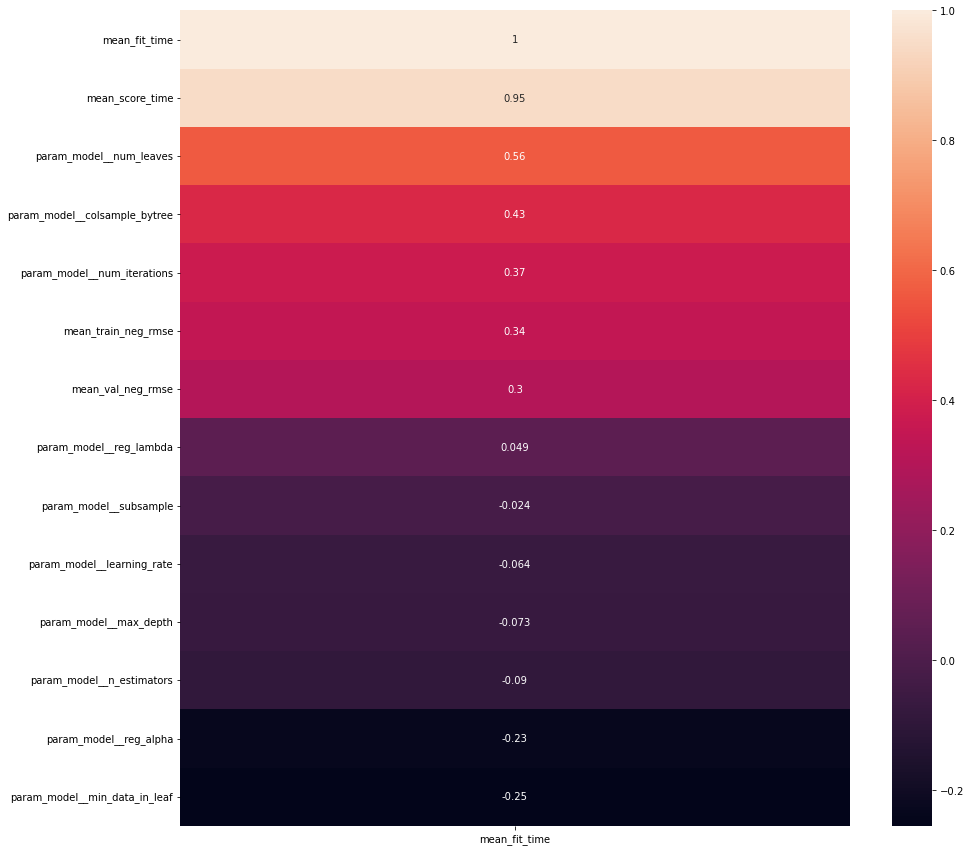

In [124]:
plt.figure(figsize=(15,15))
sns.heatmap( df_b_perf.corr(method='pearson').loc[:, ['mean_fit_time']].sort_values(by='mean_fit_time', ascending=False), 
             cbar=True, 
             annot=True )

<AxesSubplot: >

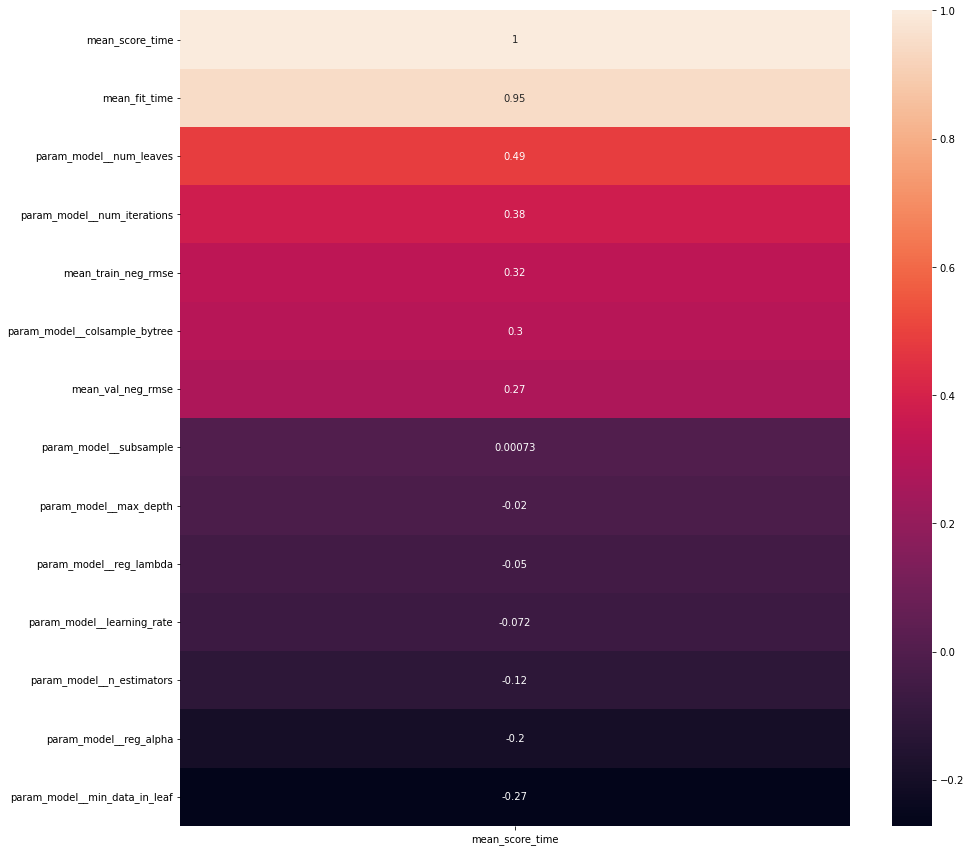

In [125]:
plt.figure(figsize=(15,15))
sns.heatmap( df_b_perf.corr(method='pearson').loc[:, ['mean_score_time']].sort_values(by='mean_score_time', ascending=False), 
             cbar=True, 
             annot=True )

<AxesSubplot: >

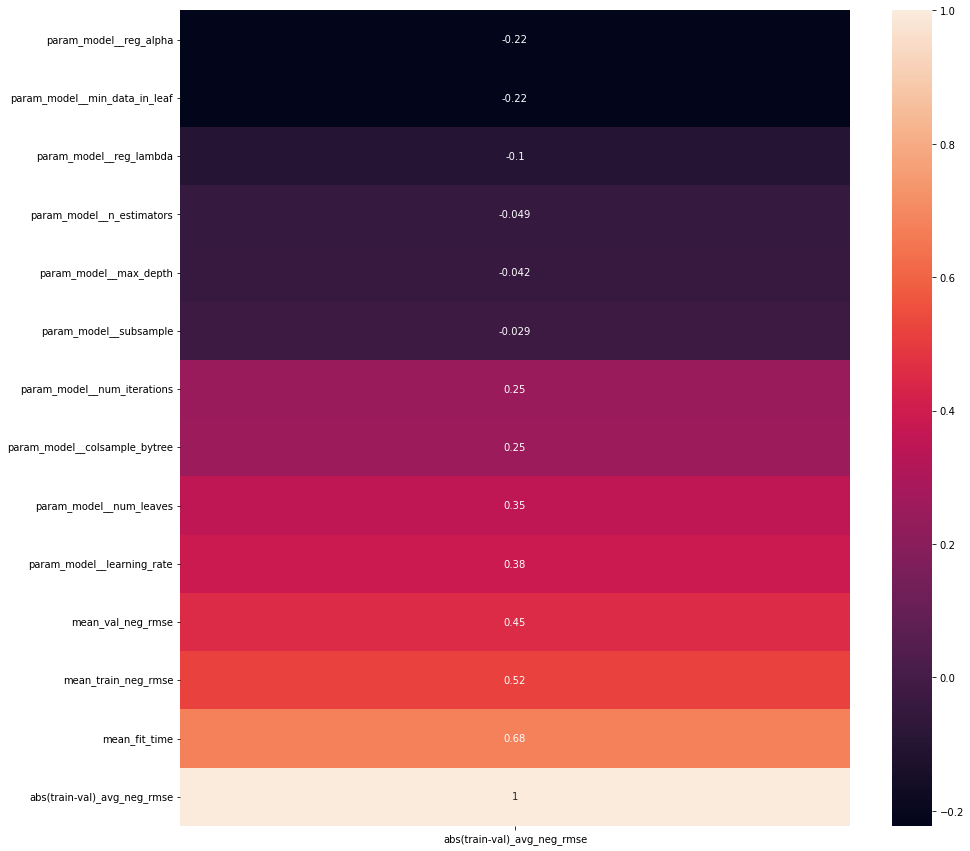

In [121]:
df_b_perf['abs(train-val)_avg_neg_rmse'] = np.abs(df_b_perf['mean_train_neg_rmse'] - df_b_perf['mean_val_neg_rmse'])
plt.figure(figsize=(15,15))
sns.heatmap( df_b_perf.corr(method='pearson').loc[:, ['abs(train-val)_avg_neg_rmse']].sort_values(by='abs(train-val)_avg_neg_rmse', ascending=True), 
             cbar=True, 
             annot=True )